In [1]:
import pandas as pd
import numpy  as np

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline 

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

In [2]:
# dataset 1
location = "https://github.com/gridflowai/gridflowAI-datasets-icons/raw/master/AI-DATASETS/01-MISC/Advertising.csv"

In [3]:
# load the adv data
df_adv = pd.read_csv(location)
df_adv.drop(['Unnamed: 0'], axis=1, inplace=True)
df_adv.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


#### 1. Assumptions - linearity

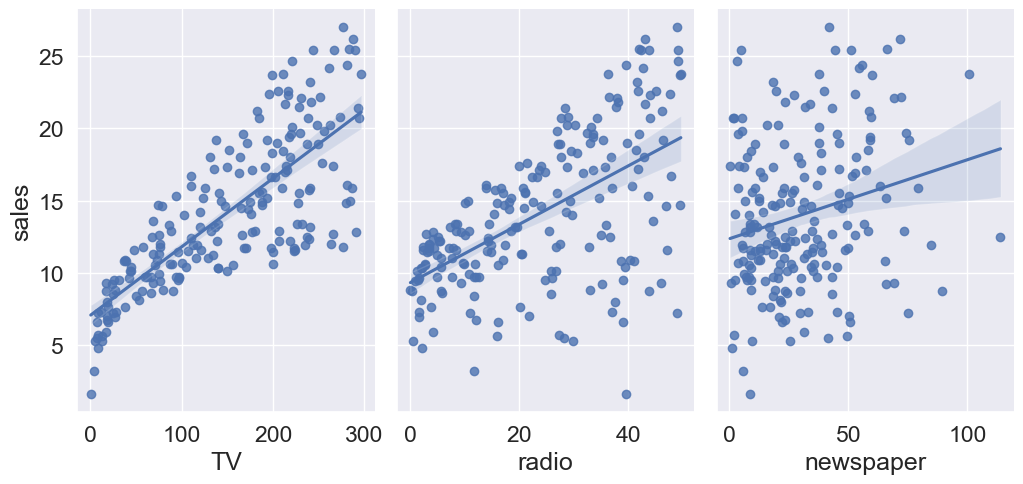

In [4]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(df_adv, 
             x_vars=['TV','radio','newspaper'], 
             y_vars='sales', 
             height=5, 
             aspect=0.7, 
             kind='reg');

In [5]:
df_adv.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


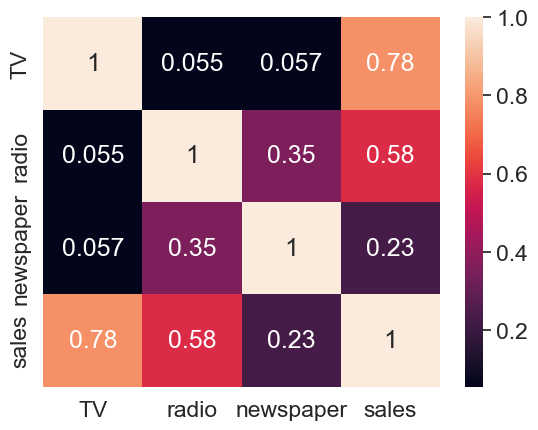

In [6]:
sns.heatmap(df_adv.corr(), annot=True);

#### develop the model

In [7]:
# create a Python list of feature names
feature_cols = ['TV', 'radio', 'newspaper']

# use the list to select a subset of the original DataFrame
X = df_adv[feature_cols]

# select a Series from the DataFrame
y = df_adv['sales']

In [8]:
# import the ML algorithm
from sklearn.linear_model import LinearRegression

In [9]:
# instantiate
linreg = LinearRegression()

In [10]:
# fit the model to the training data (learn the coefficients)
linreg.fit(X, y)

LinearRegression()

In [11]:
# make predictions on the testing set
y_pred = linreg.predict(X)

In [12]:
residuals = y - y_pred

df_residuals = pd.DataFrame(residuals)

#### Assumptions 2 - checking the normality of the residuals 
- if the residuals are normally distributed then the model we developed is good
- also if the mean of the residuals = 0 then also it means the model is good


In [13]:
residuals.mean()

-1.0302869668521452e-15

the mean is close to 0 so the model is trust worthy for predictions

#### use the statistical tests for the normality of the residuals

For the normality tests, the 

$H_0$ : the data series is normally distributed

$H_a$ : the data series is not normally distributed

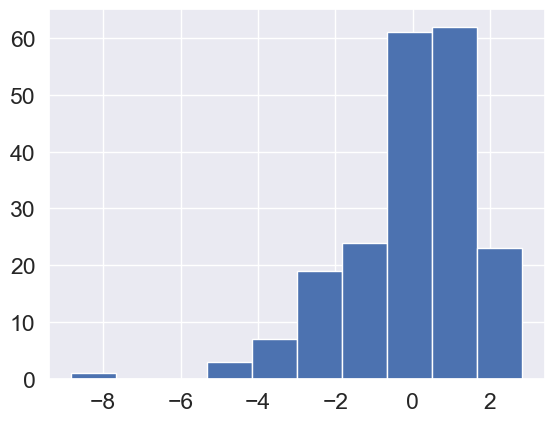

In [17]:
plt.hist(residuals);

In [18]:
from scipy.stats import shapiro
from scipy.stats import normaltest

In [19]:
# normality test
stat, p = shapiro(residuals)
print('Statistics=%.4f, p=%.4f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks normally distributed (fail to reject H0)')
else:
	print('Sample does not look Normally distributed (reject H0)')

Statistics=0.9177, p=0.0000
Sample does not look Normally distributed (reject H0)


In [20]:
# normality test
stat, p = normaltest(residuals)
print('Statistics=%.4f, p=%.4f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=60.4140, p=0.0000
Sample does not look Gaussian (reject H0)


#### Assumption 3 - homoschedascity of the residuals

In [14]:
from scipy import stats

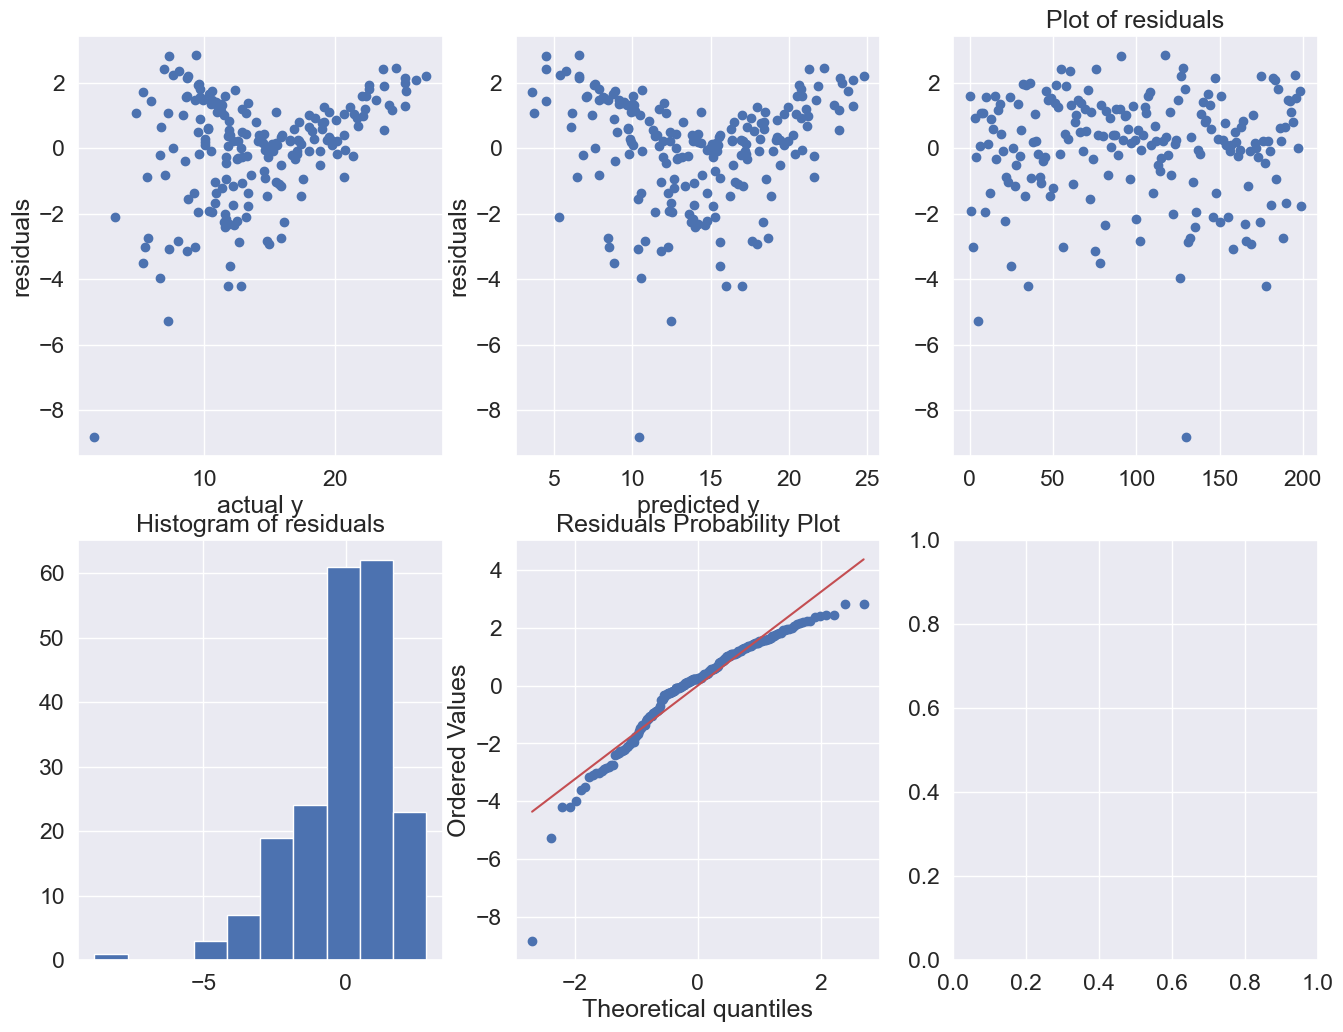

In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3 , figsize=(16, 12))

ax1.scatter(y, residuals)
ax1.set_xlabel('actual y')
ax1.set_ylabel('residuals')

ax2.scatter(y_pred, residuals)
ax2.set_xlabel('predicted y' )
ax2.set_ylabel('residuals' )

# scatter plot of residuals
ax3.scatter(range(len(residuals)), residuals)
ax3.set_title('Plot of residuals')

# histogram plot (residuals)
ax4.hist(residuals)
ax4.set_title('Histogram of residuals')

stats.probplot(residuals, plot= ax5)
ax5.set_title("Residuals Probability Plot");

#### Diagnosing Homoscedasticity - statistical way

- Brown-Forsythe test, 
- Levene’s test, 
- Bruesch-Pagan test, or 
- Cook-Weisberg test

$H_0$ = No heteroscedasticity, Homoscedasticity is present, variance is same

$H_A$ = heteroscedasticity is present

> The test for homoscedasticity of variance needs to be conducted for each level of the categorical variables.

In [23]:
import statsmodels.stats.api as sms

In [24]:
name = ['Lagrange multiplier statistic', 
        'p-value', 
        'f-value', 
        'f p-value']

bp = sms.het_breuschpagan(residuals, X.values)

In [25]:
sms.het_breuschpagan(residuals, X.values)

(25.033579588067113,
 3.664605771994266e-06,
 9.395355534009424,
 7.828453271745514e-06)

In [26]:
pd.DataFrame(name, bp)

,0
25.033580,Lagrange multiplier statistic
0.000004,p-value
9.395356,f-value
0.000008,f p-value


#### Assumption 4 - there should not be any multi - collinearity in the predictors

In [16]:
X.corr()

,TV,radio,newspaper
TV,1.000000,0.054809,0.056648
radio,0.054809,1.000000,0.354104
newspaper,0.056648,0.354104,1.000000


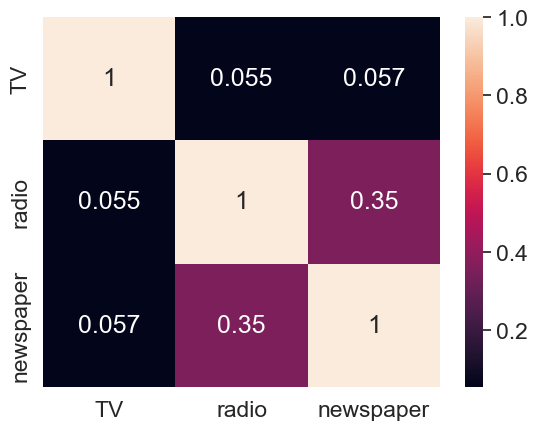

In [17]:
sns.heatmap(X.corr(), annot=True);

#### using VIF method to check multi collnearity

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# import scipy as sp

In [19]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()

vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif["feature"] = X.columns

vif.sort_values(['VIF_Factor'], ascending=False).round(5)

,VIF_Factor,feature
1,3.28546,radio
2,3.05524,newspaper
0,2.48677,TV


for a column if the VIF score is more than 10, then the column has collinearity with other columns

#### Explanation of the VIF code

In [34]:
X.values[:5]

array([[230.1,  37.8,  69.2],
       [ 44.5,  39.3,  45.1],
       [ 17.2,  45.9,  69.3],
       [151.5,  41.3,  58.5],
       [180.8,  10.8,  58.4]])

In [35]:
variance_inflation_factor(X.values, 0)

2.486771835198193

In [33]:
X.shape

(200, 3)

In [34]:
X.shape[1]

3

In [36]:
for col_index in range(X.shape[1]):
    
    vif = variance_inflation_factor(X.values, col_index)
    
    print('VIF for column : {} is {}'.format(col_index, vif))

VIF for column : 0 is 2.486771835198193
VIF for column : 1 is 3.285462100162896
VIF for column : 2 is 3.0552445106573853


In [36]:
all_vifs = []

for col_index in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, col_index)
    
    all_vifs.append(vif)

all_vifs

[2.486771835198193, 3.285462100162896, 3.0552445106573853]

In [40]:
vif_df = pd.DataFrame(data= {'column': X.columns, 'VIF': all_vifs})
vif_df

,column,VIF
0,TV,2.486772
1,radio,3.285462
2,newspaper,3.055245


In [41]:
vif_df.sort_values(['VIF'], ascending=False)

,column,VIF
1,radio,3.285462
2,newspaper,3.055245
0,TV,2.486772
